In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
from tqdm import tqdm

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 

## Time to get your hands dirty! The irreducible mass of black holes.

This is an example that comes straight out of my research in general relativity.

**Gerosa, Fabbri, Sperhake (2022) "*The irreducible mass and the horizon area of LIGO's black holes*" [arxiv:2202.08848](https://arxiv.org/abs/2202.08848), [CQG 39 (2022) 175008](https://iopscience.iop.org/article/10.1088/1361-6382/ac8332)**

(some of the calculations there were first worked out by Cecilia Fabbri in her BSc thesis with me).

Consider a rotating black hole. In [1969](https://ui.adsabs.harvard.edu/abs/1969NCimR...1..252P/abstract), Roger Penrose (now [Nobel Prize in Physics](https://www.nobelprize.org/prizes/physics/2020/penrose/facts/) for the theory of black holes) discovered that one can extract energy from a rotating black hole:

![](https://inspirehep.net/files/268d28446b405e134199d84f67c23792)

(figure from [Harada, Kimura 2014](https://ui.adsabs.harvard.edu/abs/2014CQGra..31x3001H/abstract)).

Maybe some of you has seen this already in your GR class? In any case, a rotating black-hole has a region called ergosphere such that infalling particles have negative energy. Penrose imagined a particle that enters that region and decays: half will fall in and half will escape to infinity, carring some energy with it. In a nutshell, we've extracted energy=mass from a black hole! It turns out that one also has to extract angular momentum, not just energy (and here you'll need some GR do to this calculation, see e.g. the famous textbook by [Misner, Thorne and Weeler](https://press.princeton.edu/books/hardcover/9780691177793/gravitation)). But angular momentum runs out first, such that a repeated series of Penrose processes leaves behind a non-rotating BH with a remnant mass which is called "irreducible". This is a famous result by [Christodoulou 1970](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.25.1596) and is closely related to the even more famous area law by [Hawking (1971)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.26.1344) (which in turns is the foundation of black-hole thermodynamics -- for you, my theorethical physics friend).


For a BH of mass $M$ spin $\chi\in [0,1]$, the irreducible mass is 
\begin{equation}
M_{\rm irr} = %\sqrt{\frac{M^2+\sqrt{M^4-S^2}}{2}} = 
 M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
\end{equation}
For convenience, let us define 

$$f(\chi) = \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}} = \frac{M_{\rm irr}}{M}$$

Suppose you have repeated measurments of $M$ and $\chi$. This is just because we're still frequentists for now. When we will put our Bayesian hat on, these distributions will be the *posterior samples* from a single measurement.

Let's assume that

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

These are simplistic assumption that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.

**Tasks**:

1. Start with a value of $\sigma=0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu=1$ in your code and remember that all masses in the problem are measured in units of $\mu$. 

2. Plot the resulting pdf of $M_{\rm irr}$. First try an histogram with one the rules of thumb we've seen above.

*Hint*: You don't know the functional form of the pdf of $M_{\rm irr}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!

3. Using the same samples, plot the distribution of $M_{\rm irr}$ using a KDE.

4. Compute the KS distance between ${M_{\rm irr}}$ and ${f}$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$. 

5. Compute the KS distance between ${M_{\rm irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

6. You should find that (i) $M_{\rm irr}$ is distributed like $f$ if ${\sigma}\ll \mu$ and (ii) $M_{\rm irr}$ is distributed like $M$ if  $\sigma\gg \mu$.


7. Compute the pdfs of $M_{\rm irr}$ from their mathematical definitions, plot them, and check they agree with your KDE.

*Hint (for point 7 above)*: First compute the pdf of $f$, that is just a change of variable. We saw how to do this in a previous lecture. The answer is:
\begin{equation}
\pi(f) = 2\frac{2 f^2-1}{\sqrt{1 - f^2}}\,.
\end{equation}

*Another hint (still for point 7 above)*: Then compute the pdf of $M_{\rm irr}$, you want to use [this theorem](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables) for the product of two random variables. The answer is only semi-analytic (unless you know how to solve that integral? If so please tell me!)
\begin{equation}
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\,.
\end{equation}
This can be easily solved numerically.

*Yet another hint:* If any any time you get lost in the calculation, it helps checking that your pdfs are normalized as they should.

# Code

In [21]:
N = int(1e5)
chi = np.random.uniform(0, 1, N)
mass = np.random.normal(1, 0.02, N)

In [22]:
def MassIrr(mass, chi):
    return mass*np.sqrt((1+np.sqrt(1-chi**2))/2)

mass_irr = MassIrr(mass, chi)

## Histogram

Text(0.5, 0, '$M_{irr}$')

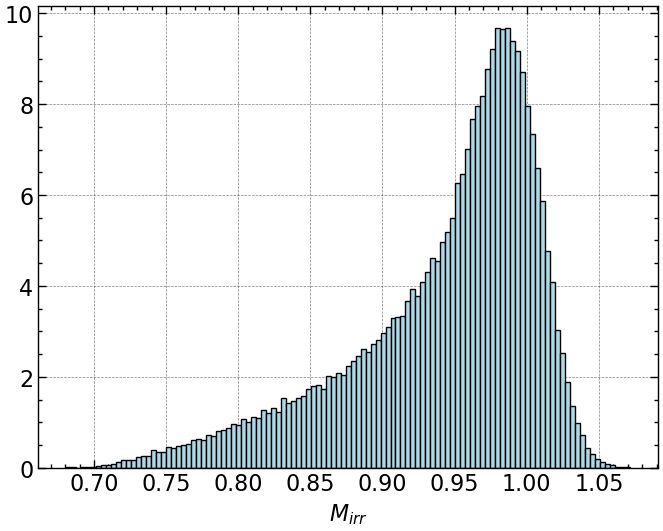

In [23]:
fancyhist(mass_irr, bins="freedman", density=True, color='lightblue', edgecolor='black');
plt.xlabel('$M_{irr}$')

## KDE

In [24]:
x_dense = np.linspace(mass_irr.min(),mass_irr.max(),1000)

def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_dense[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

Text(0.5, 0, '$M_{irr}$')

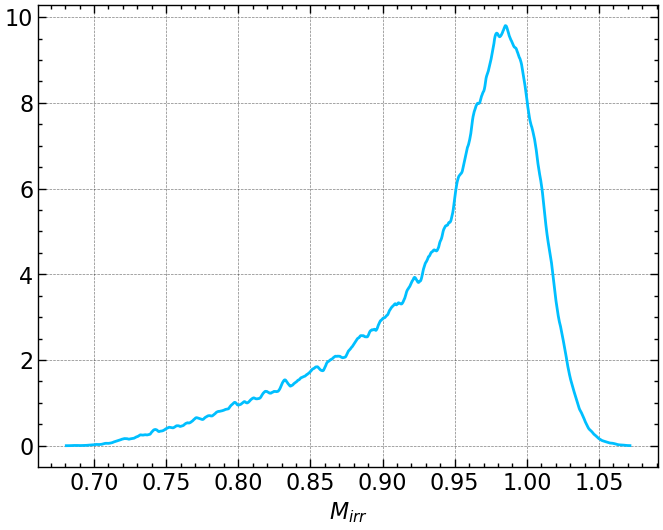

In [25]:
KDE = kde_sklearn(mass_irr, bandwidth=0.003, kernel="epanechnikov") 
plt.plot(x_dense, KDE, color='deepskyblue') 
plt.xlabel('$M_{irr}$')

## KS Test with $M_{irr}$ and $f$, $M$

In [26]:
#sigmas = np.append(np.linspace(0.0001, 0.1, 10), np.linspace(0.1, 1, 30))
sigmas = 10.**(np.linspace(-6, 2, 30))
sigmas

array([1.00000000e-06, 1.88739182e-06, 3.56224789e-06, 6.72335754e-06,
       1.26896100e-05, 2.39502662e-05, 4.52035366e-05, 8.53167852e-05,
       1.61026203e-04, 3.03919538e-04, 5.73615251e-04, 1.08263673e-03,
       2.04335972e-03, 3.85662042e-03, 7.27895384e-03, 1.37382380e-02,
       2.59294380e-02, 4.89390092e-02, 9.23670857e-02, 1.74332882e-01,
       3.29034456e-01, 6.21016942e-01, 1.17210230e+00, 2.21221629e+00,
       4.17531894e+00, 7.88046282e+00, 1.48735211e+01, 2.80721620e+01,
       5.29831691e+01, 1.00000000e+02])

In [27]:
pvalue_MirrF = []
pvalue_MirrM = []

for sigma in tqdm(sigmas):
    Mass = np.random.normal(1, sigma, N)
    Mass_irr = MassIrr(Mass, chi)
    f = MassIrr(mass=1, chi=chi)
    pvalue_MirrF.append(stats.ks_2samp(Mass_irr, f)[0])
    pvalue_MirrM.append(stats.ks_2samp(Mass_irr, Mass)[0])

100%|██████████| 30/30 [00:01<00:00, 17.09it/s]


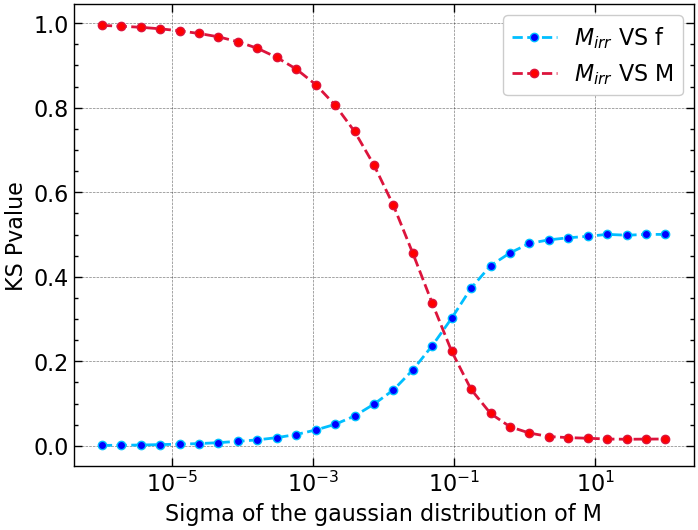

In [28]:
plt.plot(sigmas, pvalue_MirrF, linestyle='--', color='deepskyblue', marker='o', markerfacecolor='blue', label='$M_{irr}$ VS f')
plt.plot(sigmas, pvalue_MirrM, linestyle='--', color='crimson', marker='o', markerfacecolor='red', label='$M_{irr}$ VS M')
plt.xlabel('Sigma of the gaussian distribution of M')
plt.ylabel('KS Pvalue')
plt.xscale('log')
plt.legend()